# Homework 02 #

Sternbauer, k11812499

In [1]:
# Imports
import pandas as pd
import numpy as np

from scipy import stats
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

np.set_printoptions(suppress=True) #avoid scientific printing, do floating point instead

## Task 1 ##
Import the dataset *‘faithful.csv’*.

### Task 1.1 ###
Split the dataset into two set of data according to the *eruption times*. If it is less or equal than 3 minutes, split the data into *short eruption times*. Otherwise, split the observations into *long eruption times*.

In [2]:
data = pd.read_csv('faithful.csv')
display(data.head())
# Remove unnamed column (as panda dataframe has already an own index)
if 'Unnamed: 0' in data.columns: #Do if here to not run into error when executing this line multiple times
    data = data.drop(columns=['Unnamed: 0'])
data.head()

,Unnamed: 0,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [3]:
# Split dataset according to eruption time criterion
data_short = data[data['eruptions'] <= 3.0]
data_long = data[data['eruptions'] > 3.0]
display(data_short.head())
data_long.head()

,eruptions,waiting
1,1.800,54
3,2.283,62
5,2.883,55
8,1.950,51
10,1.833,54


,eruptions,waiting
0,3.600,79
2,3.333,74
4,4.533,85
6,4.700,88
7,3.600,85


### Task 1.2 ###
For short *eruption times dataset*, say you are going to test if the associated waiting last on average less than 65 minutes, write down your null and alternative hypothesis.

Null hypothesis and alternative hypothesis:

$H_0 = \overline{w}_s \geq 65$

$H_1 = \overline{w}_s < 65$

### Task 1.3 ###
Compute the t statistic and the p-value for this test. Will you reject your H0 hypothesis at *α=0.05* level? What about at *α=0.01* level? What are the advantages and disadvantages of using smaller significant level?

In [4]:
w_mean = data_short['waiting'].mean()
w = 65.0

t, pvalue = stats.ttest_1samp(data_short['waiting'], popmean=w, alternative='less')
print("t=", t, "\np-value=", pvalue)

print("Is the p-value smaller than alpha=0.05?", pvalue < 0.05)
print("Is the p-value smaller than alpha=0.01?", pvalue < 0.01)

t= -17.71610257794661 
p-value= 2.557093553296291e-32
Is the p-value smaller than alpha=0.05? True
Is the p-value smaller than alpha=0.01? True


The absolute value of the T-statistic $|T|=17.71$, which is rather high, and our p-value is smaller than both $\alpha=0.05$ and $\alpha=0.01$. This means that for both alpha values (the significant level), we can reject the null hypothesis and decide for the alternative hypothesis.

Advantages of a smaller significant level
- Less likely to have a false positive, therefore be more confident in rejecting the null hypothesis
- A higher statistical significance as there is a higher strength of evidence

Disadvantages of a smaller significant level
- Some actually true positives might also be rejected which leads to a worse sensitivity (true positive rate)
- the test is less sensitive to detect differences

### Task 1.4 ###
Test whether the average *waiting* of *short* and *long eruption times* are equal. To do this, first illustrate what assumptions must you make to carry out this test? And also explain which test you used, what is your null and alternative hypothesis, did you reject your null hypothesis and why?

In [5]:
# First show some statistical data about the two datasets
print("Waiting statistics for short eruption time")
print("Mean:   ", data_short['waiting'].mean(), "\nStdDev: ", data_short['waiting'].std(), "\nMedian: ", data_short['waiting'].median())

print("\nWaiting statistics for long eruption time")
print("Mean:   ", data_long['waiting'].mean(), "\nStdDev: ", data_long['waiting'].std(), "\nMedian: ", data_long['waiting'].median())

Waiting statistics for short eruption time
Mean:    54.49484536082474 
StdDev:  5.840097943207314 
Median:  54.0

Waiting statistics for long eruption time
Mean:    79.98857142857143 
StdDev:  5.994239161050269 
Median:  80.0


The median and mean value are rather far apart, which typically is not a good sign for similarity. On the other hand, the two computed standard deviations $\sigma$ are much closer to each other.

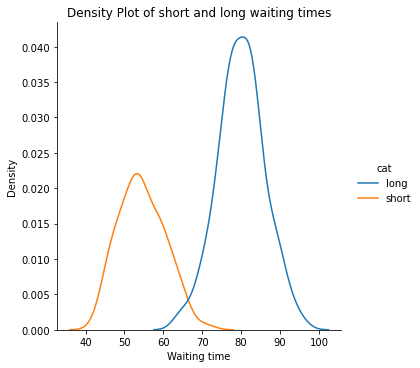

In [6]:
plot = data.copy()
plot.loc[data_short.index, 'cat'] = 'short'
plot.loc[data_long.index, 'cat'] = 'long'
sns.displot(data=plot, x='waiting', kind='kde', hue='cat')
plt.title('Density Plot of short and long waiting times')
plt.xlabel('Waiting time')
plt.ylabel('Density')
plt.show()

Assumptions for this test:
- Similiar variances between the two datasets (this is given as $\sigma$ is very close to each other)
- The two datasets must be independant from each other (this is given as we devided data via the eruption time)
- The data has to be normally distributed (see the densitity plot above)

To test, the t-tests for means of two independent samples for scores from scipy is used (see [ScipPy reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html))

The hypothesis:

$H_0: \mu_{small} = \mu_{large}$

$H_1: \mu_{small} \neq \mu_{large}$

In [7]:
t, pvalue = stats.ttest_ind(data_short['waiting'], data_long['waiting'])
print("T: ", t, "\np-value: ", pvalue)

print("Is the p-value smaller than alpha=0.05/2?", pvalue < 0.05/2)
print("Is the p-value smaller than alpha=0.01/2?", pvalue < 0.01/2)

T:  -33.90589626479086 
p-value:  2.645975019718631e-99
Is the p-value smaller than alpha=0.05/2? True
Is the p-value smaller than alpha=0.01/2? True


The absolute value of T, $|T|=33.95$ is again rather high and with a very low p-value. It would be both smaller than a significance level of $\alpha=\frac{0.05}{2}$ and $\alpha=\frac{0.01}{2}$. Therefore it is to assume that the null hypothesis $H_0$ gets rejected and the decision falls to the alternative $H_1$. Therefore the average waiting times for short and long erruptions are not the same.

## Task 2 ##

Suppose we have a dataset *(x1, y1), (x2, y2), (x3, y3), ..., (xn, yn)*, and we want to fit a linear model to this dataset in a form of $y = \beta x$ (no intercept term). Show that you can get $\hat\beta$ by the following:

\begin{equation*}
\hat\beta = \frac{S_{xy}}{S_{xx}}\\
S_{xy} = \Sigma_{i=1}^{n} x_i y_i,  \quad S_{xx} = \Sigma_{i=1}^{n} x_i^2
\end{equation*}

First of, a loss function has to be defined with which to measure how well the linear model fits to our dataset. For this, the least squared error loss function is used. The loss should be minimized. The function is defined as the sum of squared differences between the true label and the value predicted by the model.

\begin{equation}
\mathcal{L} = \Sigma_{n=1}^{n} (y_i - \beta x_i)^2
\end{equation}

To minimize, we have to derive the function by $\beta$ and set the derivation to 0 in order to find the minimum.

First, derive partial by $\beta$
\begin{align}
\frac{\partial}{\partial \beta} \mathcal{L} 
&= \frac{\partial}{\partial \hat\beta} \Sigma_{i=1}^{n} (y_i - \hat\beta x_i)^2 \\
&= \Sigma_{i=1}^{n} \frac{\partial}{\partial \hat\beta}  (y_i - \hat\beta x_i)^2 \\
&= \Sigma_{i=1}^{n} 2 \cdot (y_i - \hat\beta x_i) \cdot (-x_i)\\
&= -2 \cdot \Sigma_{i=1}^{n} x_i \cdot (y_i - \hat\beta x_i)
\end{align}

Set the derivation equal to 0 and solve for $\beta$

\begin{align}
0 &= -2 \cdot \Sigma_{i=1}^{n} x_i \cdot (y_i - \hat\beta x_i) \\
&=  \Sigma_{i=1}^{n} x_i \cdot (y_i - \hat\beta x_i)\\
&= \Sigma_{i=1}^{n} x_i \cdot (y_i - \hat\beta x_i)\\
&= \Sigma_{i=1}^{n} x_i y_i - \Sigma_{i=1}^{n} \hat\beta x_i^2 \\
&= \Sigma_{i=1}^{n} x_i y_i - \hat\beta \Sigma_{i=1}^{n}  x_i^2\\
\hat\beta \cdot \Sigma_{i=1}^{n} x_i^2 &= \Sigma_{i=1}^{n} x_i y_i \\
\hat\beta &= \frac{\Sigma_{i=1}^{n} x_i y_i}{\Sigma_{i=1}^{n} x_i^2}
\end{align}

As the numerator and denominator fit $S_{xy}$ and $S_{xx}$ respectively, it is shown that $\hat\beta$ can indeed be gotten with the given by the items from the instruction.

## Task 3 ##

Import the *‘houses.csv’* dataset.

In [8]:
data = pd.read_csv('houses.csv')
data.head()

,bathrooms,sitesize,livingsize,garages,rooms,bedrooms,age,style,fireplace,sellingprice
0,1.0,3472.0,998,1.0,7,4,42,colonial,no,25900
1,1.0,3531.0,1500,2.0,7,4,62,colonial,no,29500
2,1.0,2275.0,1175,1.0,6,3,40,colonial,no,27900
3,1.0,4050.0,1232,1.0,6,3,54,colonial,no,25900
4,1.0,4455.0,1121,1.0,6,3,42,colonial,no,29900


### Task 3.1 ###

Fit a linear regression of *sellingprice* as a function of *livingsize* using. Print the summary of this linear model and interpret **all of** the useful information you can get from the summary.

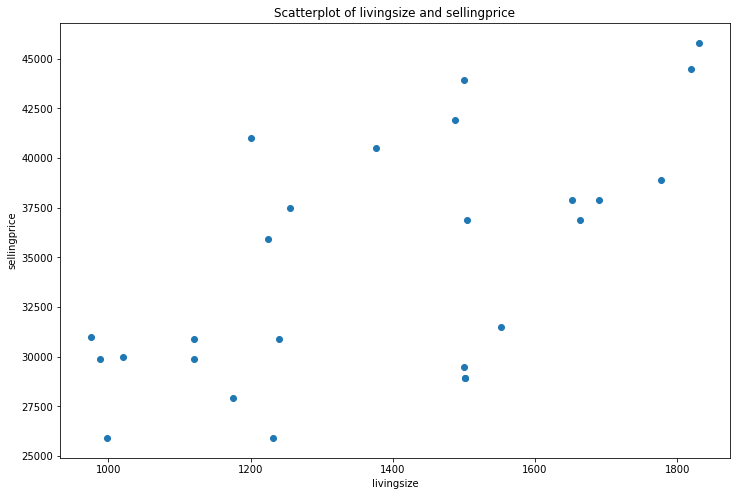

In [9]:
data_livsel = data[['livingsize', 'sellingprice']]
val = data_livsel.values

# Plot the two data columns against each other in a scatterplot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(val[:, 0], val[:, 1])
ax.set_title('Scatterplot of livingsize and sellingprice');
ax.set_xlabel('livingsize')
ax.set_ylabel('sellingprice');

In [10]:
model = LinearRegression() # Load a linear regression model https://scikit-learn.org/stable/modules/linear_model.html
X_val = val[:, 0].reshape(-1, 1) #pack each value into its own array (holds 1 value only)
y_val = val[:, 1]
model.fit(X_val,y_val);
print("Key characteristics of the fitted sklearn linear model")
print("\nIntercept: ", model.intercept_, "\nSlope: ", model.coef_[0])

Key characteristics of the fitted sklearn linear model

Intercept:  15295.208164249503 
Slope:  14.006310405478402


In [11]:
linregress = stats.linregress(val[:, 0], y_val) #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html#scipy.stats.linregress
print("Key characteristics of the fitted scipy linear model")
print("Intercept: ", linregress.intercept, "\nSlope: ", linregress.slope, "\np-Value: ", linregress.pvalue, "\nr-Value: ", linregress.rvalue)
print("Std-Err: ", linregress.stderr, "\nIntercept Std-Err: ", linregress.intercept_stderr)

Key characteristics of the fitted scipy linear model
Intercept:  15295.2081642495 
Slope:  14.006310405478406 
p-Value:  0.0006245162196361209 
r-Value:  0.6260038769923945
Std-Err:  3.561520443477435 
Intercept Std-Err:  5007.203555793075


In [12]:
# Run some predictions on our model
X_sort = np.sort(val[:, 0]) # First sort x-values from smallest to largest
predictions_sort = np.round(model.predict(X_sort.reshape(-1, 1)), 1) #run prediction on the sorted values
conc = np.zeros((X_sort.size, 2))
for x in range(X_sort.size):
    conc[x][0] = X_sort[x]
    conc[x][1] = predictions_sort[x]

print(conc) #print x value and prediction base on it

ols_model1 = ols('sellingprice ~ livingsize', data=data_livsel).fit()
anova_table = sm.stats.anova_lm(ols_model1, typ=3)
display(anova_table)

[[  975.  28951.4]
 [  988.  29133.4]
 [  998.  29273.5]
 [ 1020.  29581.6]
 [ 1121.  30996.3]
 [ 1121.  30996.3]
 [ 1175.  31752.6]
 [ 1200.  32102.8]
 [ 1225.  32452.9]
 [ 1232.  32551. ]
 [ 1240.  32663. ]
 [ 1256.  32887.1]
 [ 1376.  34567.9]
 [ 1488.  36136.6]
 [ 1500.  36304.7]
 [ 1500.  36304.7]
 [ 1501.  36318.7]
 [ 1501.  36318.7]
 [ 1504.  36360.7]
 [ 1552.  37033. ]
 [ 1652.  38433.6]
 [ 1664.  38601.7]
 [ 1690.  38965.9]
 [ 1777.  40184.4]
 [ 1820.  40786.7]
 [ 1831.  40940.8]]


,sum_sq,df,F,PR(>F)
Intercept,2.133666e+08,1.0,9.33083,0.005448
livingsize,3.536574e+08,1.0,15.46595,0.000625
Residual,5.488041e+08,24.0,NaN,NaN


From the model the two parameters intercept ($\beta_0$) and slope ($\beta_1$) can be read and they are `15295.21` and `14.01` respectivly. Given the regular form of the linear regression function $y = \beta_0 + \beta_1x$ and $\beta_0 = 15295.21$, $\beta_1 = 14.01$ this results into our particulary linear regression function being $y = 15295.21 + 14.01x$.

Further values that could be read from the statistics are an `rvalue` of `0.626`, indicating a positive, however not ultra strong, linear relationship between our two parameters livingsize and sellingprice. With the very small `pvalue` of 0.000624 it indicates that we can safely reject the null hypothesis and the coefficient is a meaningfull addition to our model. This further on means that 'livingsize' has a large influence on the outcome of sellingprice and can explain it.

Finally, the gotten linear function is plotted in the scatter plot from before

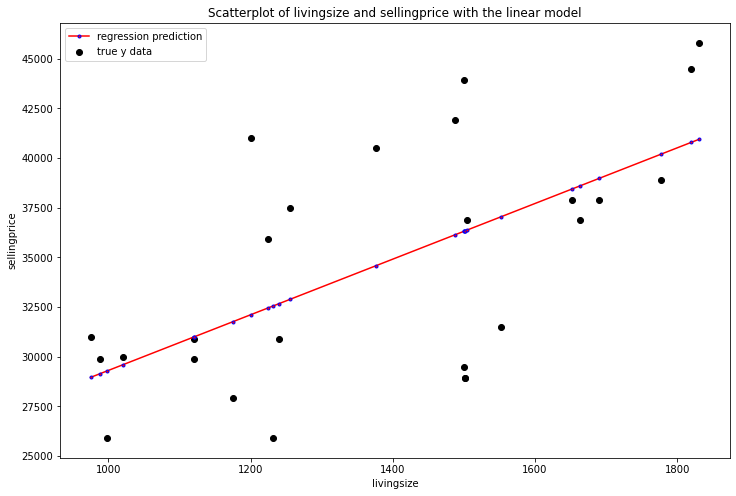

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(val[:, 0], val[:, 1], label='true y data', color='k')
ax.plot(
    X_sort, 
    predictions_sort, 
    marker='.', 
    markeredgecolor='b', 
    linestyle='-', 
    color='r',
    label='regression prediction',
)
ax.set_title('Scatterplot of livingsize and sellingprice with the linear model')
ax.set_xlabel('livingsize')
ax.set_ylabel('sellingprice')
ax.legend(loc='best');

### Task 3.2 ###

Setup a X design matrix (manually in the program)

According to the slides, the intercept variable $\beta_0$ is set to 1 for each entry, therefore the first entry in every row is set to 1 and $\beta_1$ comes as the second item.

In [14]:
X = np.concatenate([np.ones((X_val.shape[0], 1)), X_val], axis=1)
print('design matrix X:\n', X)

design matrix X:
 [[   1.  998.]
 [   1. 1500.]
 [   1. 1175.]
 [   1. 1232.]
 [   1. 1121.]
 [   1.  988.]
 [   1. 1240.]
 [   1. 1501.]
 [   1. 1225.]
 [   1. 1552.]
 [   1.  975.]
 [   1. 1121.]
 [   1. 1020.]
 [   1. 1501.]
 [   1. 1664.]
 [   1. 1488.]
 [   1. 1376.]
 [   1. 1500.]
 [   1. 1256.]
 [   1. 1690.]
 [   1. 1820.]
 [   1. 1652.]
 [   1. 1777.]
 [   1. 1504.]
 [   1. 1831.]
 [   1. 1200.]]


### Task 3.3 ###

Calculate $\hat\beta$ by using least square method (compute it manually in matrix form), confirm you get the same result from the coefficients you got from Q3.1.

To manually calculate $\hat\beta$, the following formular is used: $\hat\beta = (X^tX)^{-1}X^tY$

In [15]:
XtX_inv = np.linalg.inv(X.T @ X)
XtY = X.T @ y_val
beta = XtX_inv @ XtY
beta0, beta1 = beta

print("Intercept: ", beta0)
print("Slope: ", beta1)

Intercept:  15295.20816424943
Slope:  14.006310405478416


As manually calculated, $\beta_0 = 15295.21$ and $\beta_1 = 14.01$, which matches the calculated results from above that were calculated by the Linear Regression model from before.

\begin{equation}
\hat{\beta} = 
    \begin{pmatrix} 15295.21 \\ 
    14.01 
\end{pmatrix} 
\end{equation}

### Task 3.4 ###

What is the degree of freedom of this model? Please explain how you get this
number.

Usually, the degrees of freedom are calculated as $df = n-k$ where $n$ refers to the number of samples and $k$ to the number of parameters including the intercept term (i.e. $|\hat\beta|$).

In [16]:
print("Shape of sample vector X:  ", X.shape)
print("Shape of target vector y:  ", y_val.shape)
print("Shape of parameter vector: ", beta.shape)

Shape of sample vector X:   (26, 2)
Shape of target vector y:   (26,)
Shape of parameter vector:  (2,)


In this case, $n=26$ and $k= |\hat\beta|=2$, therefore $df = 26-2 = 24$. The degree of freedom for this model therefore is **24**.

### Task 3.5 ###

Calculate the mean square error(MSE) (Manually in matrix form)

The mean squared error for a given regression function $f$ and input $x$ is given as followed:  $MSE(f, x) = E(Y-f(x))^2$ where $Y$ is the true target value, in our case the selling price and $f(x)$ is the estimated selling price from our model. This holds for a single value. If we have more than one sample, then the mean is the average over all squared error terms.

$MSE = \frac{1}{n}\Sigma_{i=1}^{n}(Y_i - f(x_i))^2\$

In [17]:
y_pred = model.predict(X_val)
y_true = y_val

serror = (y_true - y_pred) ** 2
mse = serror.mean()
print("Mean Squared Error (MSE):   ", mse)
meanerror = np.sqrt(mse)
print("Root of Mean Squared Error: ", meanerror)

Mean Squared Error (MSE):    21107851.54071137
Root of Mean Squared Error:  4594.3281925338515


$MSE = 21107851.54$  
$RMSE = 4594.33$

### Task 3.6 ###

Calculate $cov(\hat\beta)$ as a matrix, confirming that these main variances match the result from Q 3.1.

The necessesary formular for the residual variance is as follows:  
$s^2 = \frac{1}{n-p-1} \Sigma_{i=1}^{n} (y_i - \hat y_i)^2$

In this formular, $n$ is the number of rows in our data and $p$ the length of the $\hat\beta$ vector. With this information, the covariance matrix can be roughly calculated as:  
$Cov(\hat\beta) = \sigma^2 (X^tX)^{-1} \approx s^2(X^tX)^{-1}$

In [18]:
res = y_true - y_pred
sum_res = np.sum(res ** 2)
s2 = sum_res / (X.shape[0] - X.shape[1])
print("Residual variance s2: ", s2)

cov_beta = s2 * XtX_inv
print(cov_beta)

orig_params = ols_model1.cov_params()
print(orig_params)

print("\nComparison to show ratio between the params:\n", cov_beta / orig_params)

Residual variance s2:  22866839.169103984
[[25072087.44914683   -17517.68275012]
 [  -17517.68275012       12.68442787]]
               Intercept    livingsize
Intercept   2.507209e+07 -17517.682750
livingsize -1.751768e+04     12.684428

Comparison to show ratio between the params:
             Intercept  livingsize
Intercept         1.0         1.0
livingsize        1.0         1.0


The manually calculated params match the ones which where automatically calculated by the model in Q3.1

### Task 3.7 ###

Fit a linear regression of *sellingprice* as a function of *livingsize*, *age*, and *sitesize*. Print the summary of this linear model.

In [19]:
df_data = data[['livingsize', 'age', 'sitesize', 'sellingprice']]
val = df_data.values
X_val = val[:, :3]
y_val = val[:, 3:]

print("Shape of X: ", X_val.shape, "\nShape of y: ", y_val.shape)

Shape of X:  (26, 3) 
Shape of y:  (26, 1)


In [20]:
model = LinearRegression()
X = X_val
y = y_val.ravel()
model.fit(X, y)
print("Key characteristics of the fitted sklearn linear model")
print("\nIntercept: ", model.intercept_, "\nSlope coefficients: ", model.coef_)

ols_model2 = ols('sellingprice ~ livingsize + age + sitesize', data=df_data).fit()
anova_table = sm.stats.anova_lm(ols_model2, typ=3)
display(anova_table)

Key characteristics of the fitted sklearn linear model

Intercept:  21034.53018640742 
Slope coefficients:  [  12.04223611 -127.32110305    0.27578092]


,sum_sq,df,F,PR(>F)
Intercept,2.717923e+08,1.0,13.066420,0.001536
livingsize,1.846457e+08,1.0,8.876844,0.006917
age,6.719468e+07,1.0,3.230385,0.086026
sitesize,5.166618e+06,1.0,0.248385,0.623160
Residual,4.576181e+08,22.0,NaN,NaN


For this linear model, we again have an intercept term and this time three coefficients for the slope (one for each variable it depends on).

\begin{equation}
\hat\beta =
    \begin{pmatrix}
        21034.53\\
        12.04\\
        -127.32\\
        0.27
    \end{pmatrix}
\end{equation}

For this model, the individual attributes do not have as strong a influence as our single attribute had in Q3.1, however they perform very well together. Non of them is individually significant enough, but alltogether they do indeed outperform the first model which only depends on a single attribute and an intercept term to perform the linear regression.

The `PR(>F)` (pvalue) value for livingsize is not as small as it was before, but still very much smaller than $0.01$ and therefore indicating a significant influence of this attribute on the whole model. Age does not perform as well, but its value higher than $0.05$, but still smaller than $0.01$, which indicates that it is still an important characteristic, but far less for the prediction than livingsize. Sitesize has a very large pvalue, indicating it is not much contributing / not a significant predictor for this model.

### Task 3.8 ###

Calculate the least square estimator for the y-intercept and three slopes (i.e. calculate $\hat\beta$) “by hand” similar as Q3.3. Also check that you are doing it correct by comparing the result from Q3.6.

Assumption: It was Q3.7, not Q3.6, that was meant

In [21]:
X = np.concatenate([np.ones((X_val.shape[0], 1)), X_val], axis=1)
XtX_inv = np.linalg.inv(X.T @ X)
XtY = X.T @ y_val
beta = XtX_inv @ XtY
beta0, beta1, beta2, beta3 = beta
print("Intercept: ", beta0)
print("Slope livingsize: ", beta1)
print("Slope age: ", beta2)
print("Slope sitesize: ", beta3)

Intercept:  [21034.53018641]
Slope livingsize:  [12.04223611]
Slope age:  [-127.32110305]
Slope sitesize:  [0.27578092]


As in task Q3.3, the manually calculated terms match the terms from the model perfectly.  

\begin{equation}
\hat\beta =
    \begin{pmatrix}
        21034.53\\
        12.04\\
        -127.32\\
        0.27
    \end{pmatrix}
\end{equation}

### Task 3.9 ###

Calculate the variance-covariance matrix of $\hat\beta$ “by hand” using a similar process as Q 3.5.

Assumption: It was Q3.6, not Q3.5, that was meant

In [22]:
y_pred = model.predict(val[:, :3])
y_true = y_val.ravel()
res = y_true - y_pred
sum_res = np.sum(res ** 2)
s2 = sum_res / (X.shape[0] - X.shape[1])
print("Residual variance s2: ", s2)

cov_beta = s2 * XtX_inv
print(cov_beta)

orig_params = ols_model2.cov_params()
print(orig_params)

print("\nComparison to show ratio between the params:\n", cov_beta / orig_params)

Residual variance s2:  20800824.867937725
[[33861720.8353882    -14781.71150683  -235065.3074685      -650.26304641]
 [  -14781.71150683       16.33637503      -14.87910137       -1.18737936]
 [ -235065.3074685       -14.87910137     5018.18230287       11.51890473]
 [    -650.26304641       -1.18737936       11.51890473        0.30619822]]
               Intercept    livingsize            age    sitesize
Intercept   3.386172e+07 -14781.711507 -235065.307468 -650.263046
livingsize -1.478171e+04     16.336375     -14.879101   -1.187379
age        -2.350653e+05    -14.879101    5018.182303   11.518905
sitesize   -6.502630e+02     -1.187379      11.518905    0.306198

Comparison to show ratio between the params:
             Intercept  livingsize  age  sitesize
Intercept         1.0         1.0  1.0       1.0
livingsize        1.0         1.0  1.0       1.0
age               1.0         1.0  1.0       1.0
sitesize          1.0         1.0  1.0       1.0


Again, the manually calculated results match the ones from the model pretty well. The formular approach was the same as in Q3.6

As this tasks description mentions Q3.5, even though I assume this is a mere typo and 3.6 was meant, the MSE and RMSE are once again recalculated. The formulars are the same as in Q3.5 and will not be written down here again.

In [23]:
serror = (y_true - y_pred) ** 2
mse = serror.mean()
print("Mean Squared Error (MSE):   ", mse)
meanerror = np.sqrt(mse)
print("Root of Mean Squared Error: ", meanerror)

Mean Squared Error (MSE):    17600697.965178076
Root of Mean Squared Error:  4195.318577316635


$MSE = 21107851.54$  
$RMSE = 4594.33$

According to this results, the second model with more attributes performs better on the data, resulting in less overall error between the real value and the predicted one.